# Requirements

In [ ]:
%pip install pandas numpy matplotlib seaborn 
!pip install scikit-learn
%pip install imbalanced-learn

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.stats import kstest, kruskal

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

# Data

In [3]:
INPUT_PATH = '../data/credit_card_clients.csv'
data = pd.read_csv(INPUT_PATH)

data.rename(columns={'default payment next month': 'target'}, inplace=True)
data.drop(["ID"], axis=1, inplace=True)

display("Total rows: " + str(len(data)))
display("Columns: " + ", ".join(list(map(str, data.columns))))
display(data.head(10))

'Total rows: 30000'

'Columns: LIMIT_BAL, SEX, EDUCATION, MARRIAGE, AGE, PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6, BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6, PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6, target'

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   
5      50000    1          1         2   37      0      0      0      0   
6     500000    1          1         2   29      0      0      0      0   
7     100000    2          2         2   23      0     -1     -1      0   
8     140000    2          3         1   28      0      0      2      0   
9      20000    1          3         2   35     -2     -2     -2     -2   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...      20940      19146      19131      2000     36681     10000   
5      0  ...      19394      19619      20024      2500      1815       657   
6      0  ...     542653     483003     473944     55000     40000     38000   
7      0  ...        221       -159        567       380       601         0   
8      0  ...      12211      11793       3719      3329         0       432   
9     -1  ...          0      13007      13912         0         0         0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  target  
0         0         0         0       1  
1      1000         0      2000       1  
2      1000      1000      5000       0  
3      1100      1069      1000       0  
4      9000       689       679       0  
5      1000      1000       800       0  
6     20239     13750     13770       0  
7       581      1687      1542       0  
8      1000      1000      1000       0  
9     13007      1122         0       0  

[10 rows x 24 columns]

In [4]:
y = data['target'].copy()
X = data.copy()
X.drop(['target'], axis=1, inplace=True)

df_X = X.copy()
df_y = y.copy()

In [5]:
data.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
target       0
dtype: int64

## Data Normalization

In [19]:
scaler =  StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# EDA

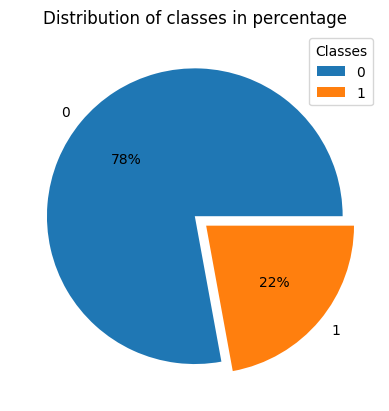

'Perc. of class 1: 22.12 %'

In [45]:
plt.figure()

values = data['target'].value_counts()
keys = [0, 1]
explode = [0, 0.1]
plt.pie(values, labels=keys, explode=explode, autopct='%.0f%%')

plt.legend(title='Classes')
plt.title('Distribution of classes in percentage')
plt.show()

display("Perc. of class 1: " + str(data['target'].sum() / data.shape[0] * 100) + " %")

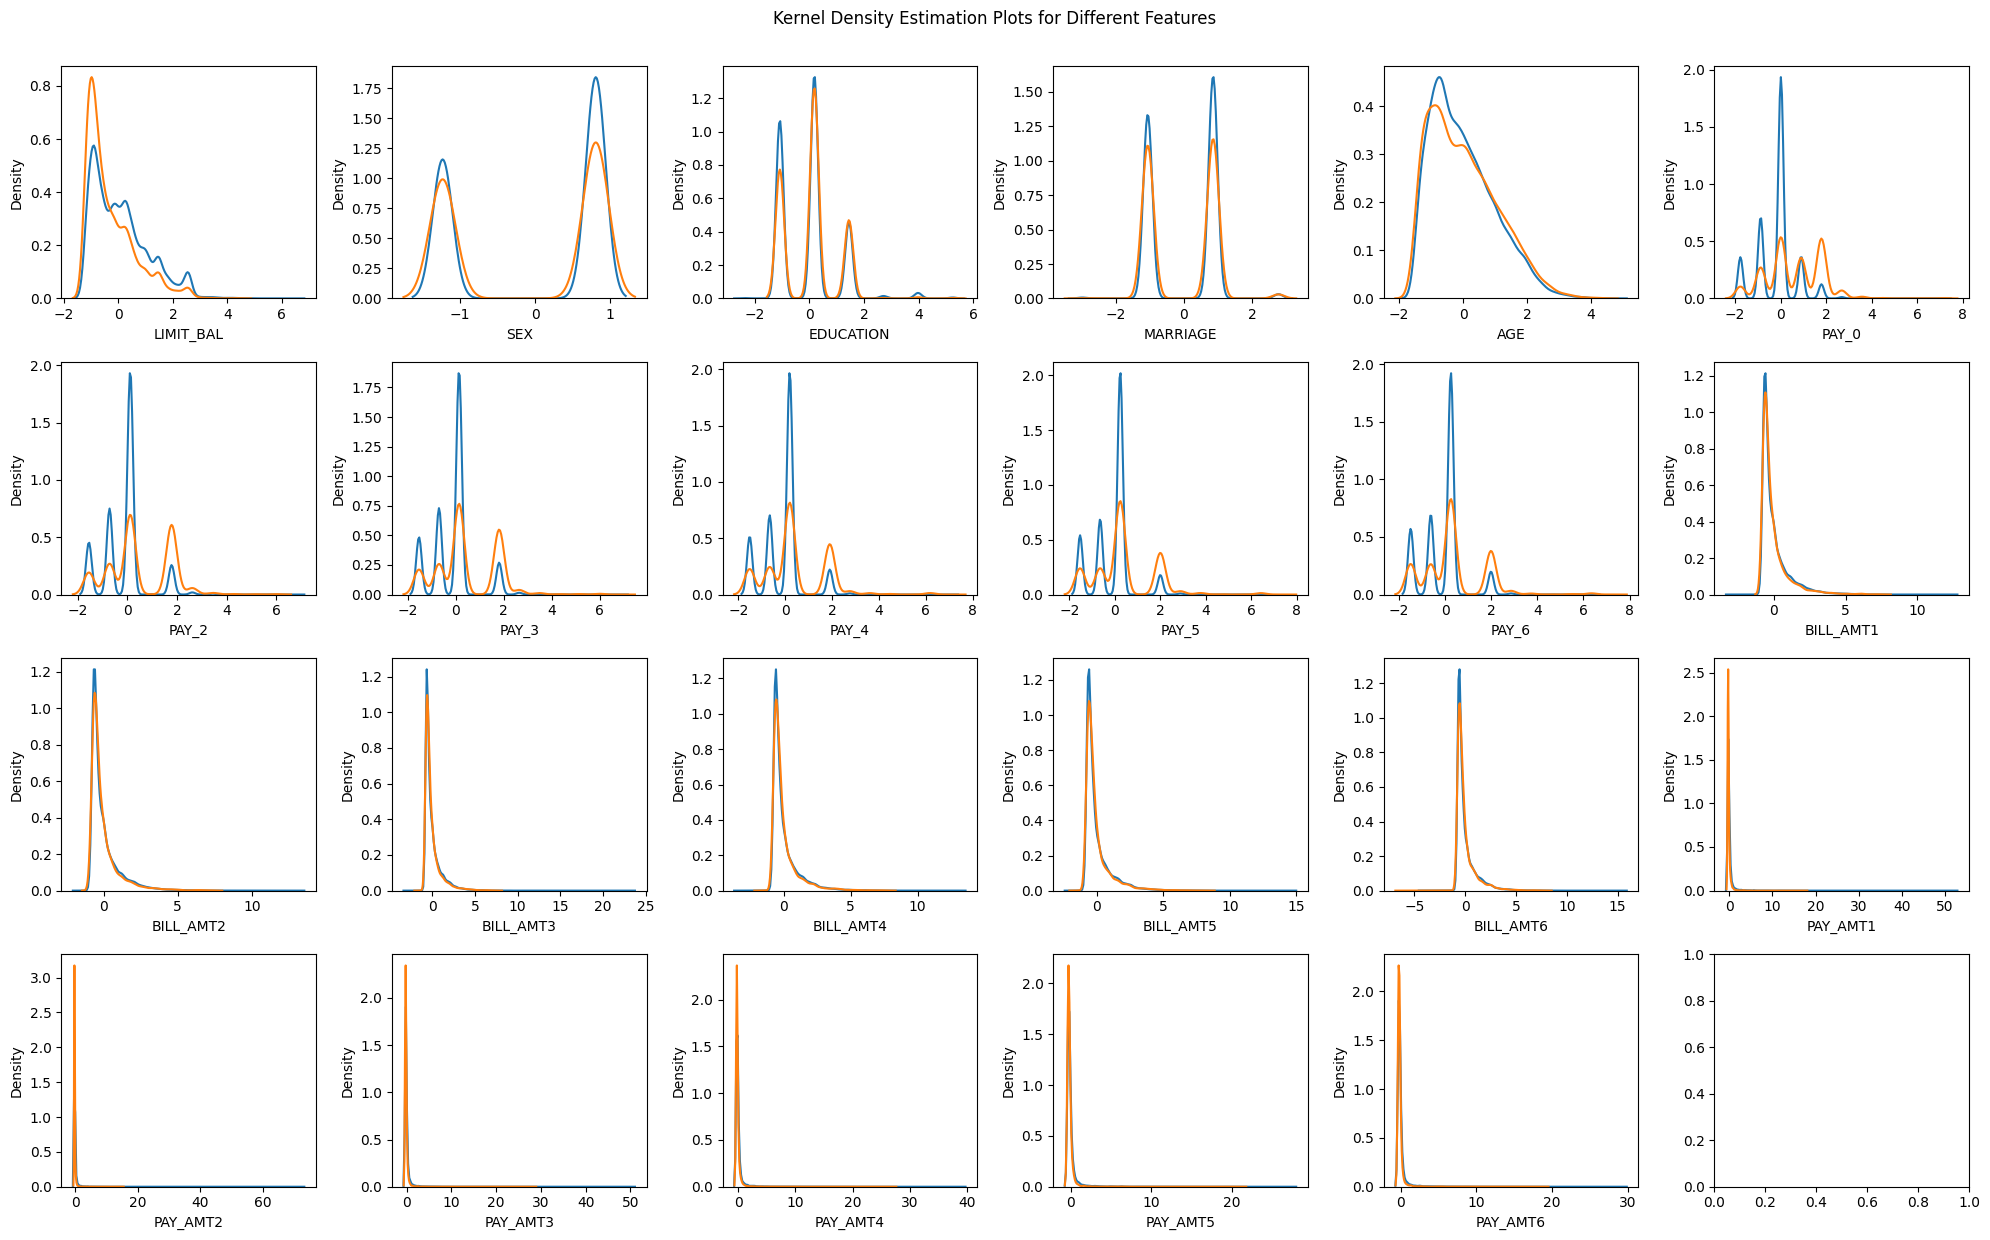

In [9]:
fig, axes = plt.subplots(4, 6, figsize=(20, 13))

for i in range(len(X.columns)):
    sns.kdeplot(ax=axes[i//6, i%6], data=X[y == 0][X.columns[i]])
    sns.kdeplot(ax=axes[i//6, i%6], data=X[y == 1][X.columns[i]])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Kernel Density Estimation Plots for Different Features')
plt.show()

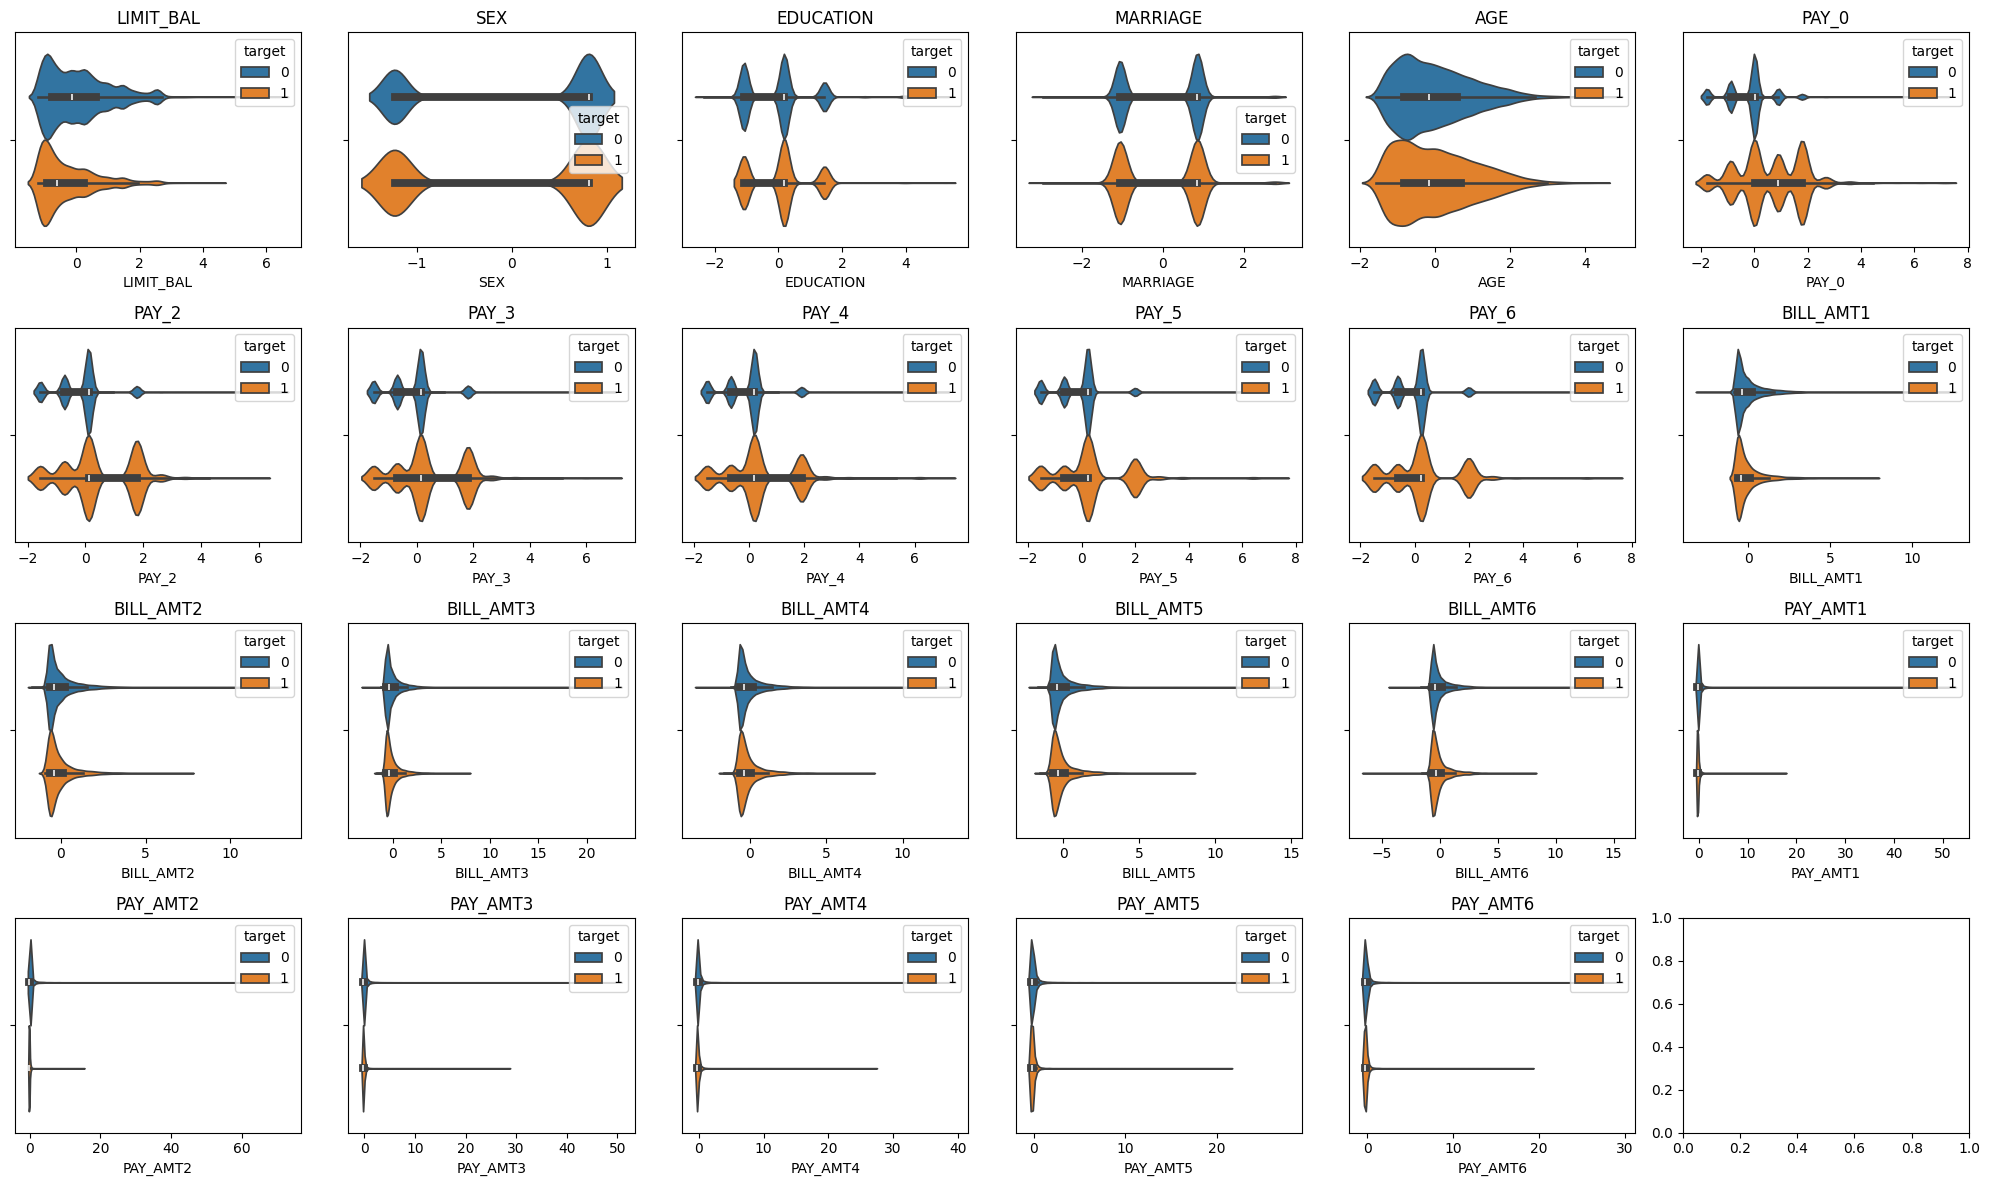

In [10]:
fig, axes = plt.subplots(4, 6, figsize=(20, 13))

for i, col in enumerate(X.columns):
    sns.violinplot(data=X, x=col, hue=y, ax=axes[i//6, i%6])
    axes[i//6, i%6].set_title(f'{col}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

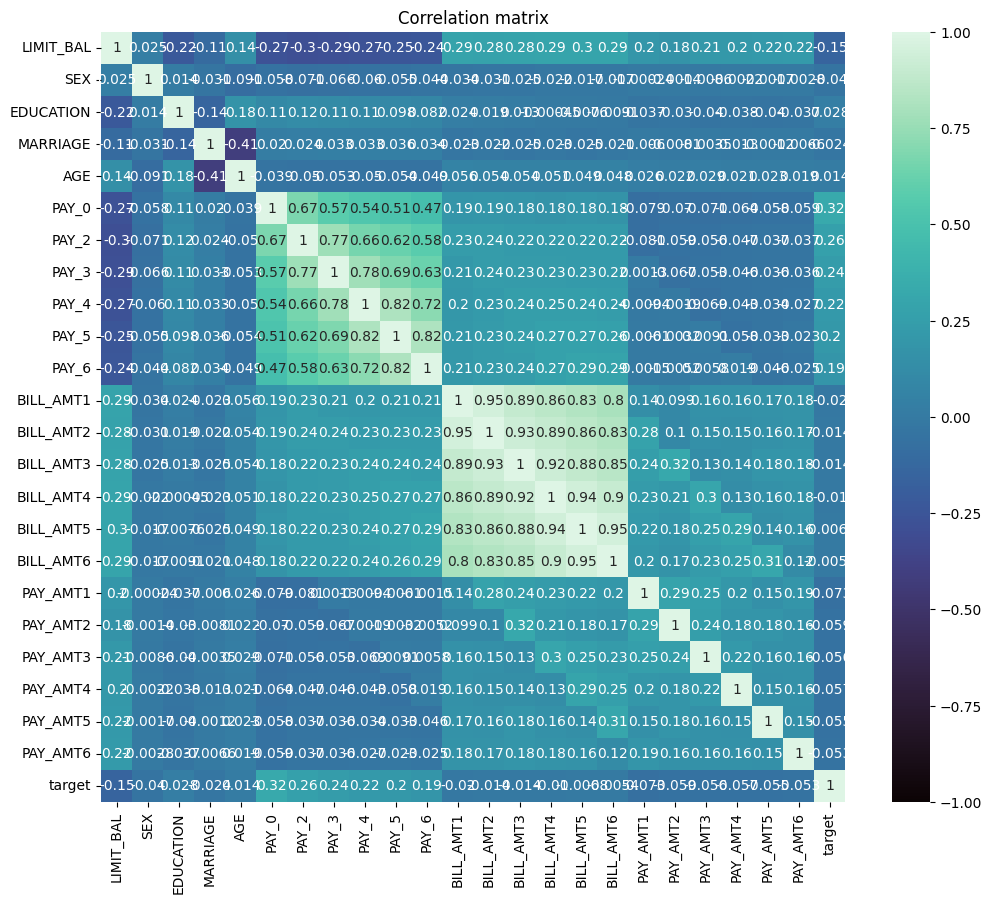

In [11]:
corr = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title("Correlation matrix")
plt.show()

# KS-test

In [46]:
ks_statistic = []
p_value = []
for feature in X.columns:
    ks, p= kstest(X[feature], 'norm')
    ks_statistic.append(ks)
    p_value.append(p)
print(X.columns)
print(ks_statistic)
print(p_value)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')
[0.115112967654111, 0.3948094340230941, 0.24725638863894117, 0.3476075931282819, 0.09440123896362657, 0.26680506063616516, 0.3075829925981671, 0.3043451619381855, 0.30814591279120274, 0.30820343204121703, 0.2974476947239121, 0.2366617340063037, 0.23686533499280138, 0.2399627335990372, 0.24081271192600953, 0.2434495083469547, 0.24576619130695798, 0.36619741408756495, 0.3985934322501699, 0.38330911635361176, 0.3790173640730474, 0.3767088296491745, 0.38461506904495213]
[0.0, 0.0, 0.0, 0.0, 3.962027152617041e-233, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# KW-Test

In [47]:
rank = [ (feature, kruskal(X[feature], y)[0]) for feature in X.columns ]
rank.sort(key=lambda x: x[1], reverse=True)

print("K-W Feature ranking:\n" + "\n".join(f"{feature:<10} | {h_stat:.2f}" for feature, h_stat in rank))

K-W Feature ranking:
PAY_AMT6   | 23702.21
PAY_AMT3   | 21591.27
PAY_AMT2   | 20982.74
PAY_AMT4   | 19374.24
PAY_AMT1   | 19270.67
PAY_AMT5   | 19210.45
BILL_AMT6  | 10893.89
BILL_AMT5  | 10809.71
BILL_AMT1  | 10608.73
BILL_AMT4  | 10216.06
BILL_AMT2  | 9874.18
BILL_AMT3  | 9671.52
LIMIT_BAL  | 3102.06
AGE        | 2694.41
PAY_0      | 1331.28
MARRIAGE   | 1108.18
PAY_2      | 615.24
PAY_3      | 482.09
PAY_4      | 382.74
EDUCATION  | 365.70
PAY_5      | 297.08
SEX        | 176.91
PAY_6      | 126.67


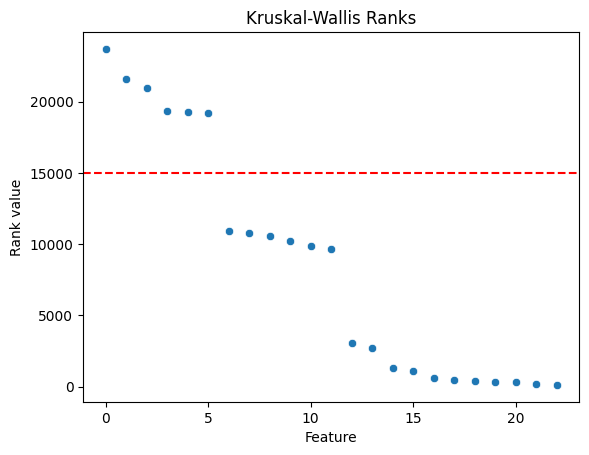

In [48]:
rank = pd.DataFrame(rank)
plt.figure()
sns.scatterplot(rank[1])
plt.axhline(y = 15000, color='r', linestyle='--')

plt.title("Kruskal-Wallis Ranks")
plt.ylabel("Rank value")
plt.xlabel("Feature")
plt.show()

# PCA

In [49]:
exp_pca = PCA(n_components=X.shape[1])
exp_pca.fit(X)

eigenvalue = pd.DataFrame(exp_pca.explained_variance_ratio_)
index_lambda = list(range(eigenvalue.shape[0]))
R = lambda i: eigenvalue[0][index_lambda[:i]].pow(2).sum() / eigenvalue[0].pow(2).sum() * 100
preserved_variance = pd.DataFrame([R(i+1) for i in index_lambda])

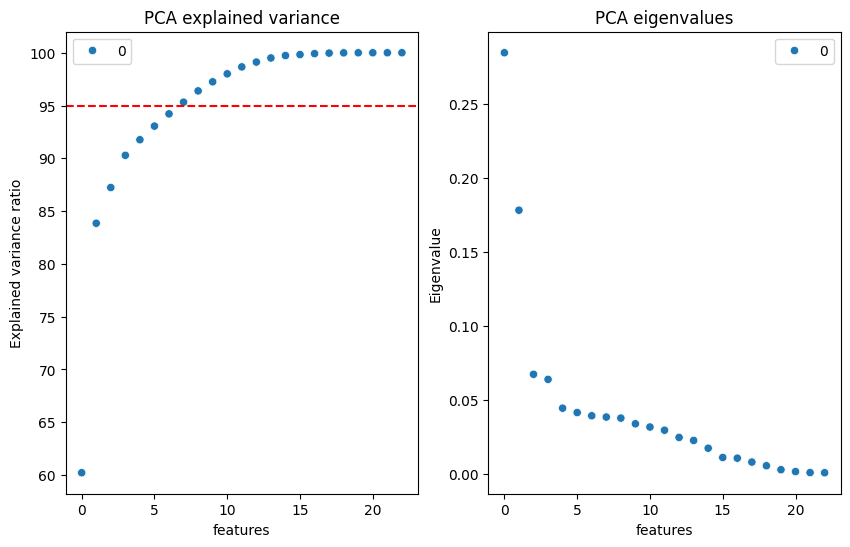

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

sns.scatterplot(ax=axes[0], data=preserved_variance)
sns.scatterplot(ax=axes[1], data=eigenvalue)

axes[0].axhline(y=95, color='r', linestyle='--')
axes[0].set_title("PCA explained variance")
axes[0].set_xlabel("features")
axes[0].set_ylabel("Explained variance ratio")
axes[1].set_title("PCA eigenvalues")
axes[1].set_xlabel("features")
axes[1].set_ylabel("Eigenvalue")
plt.show()

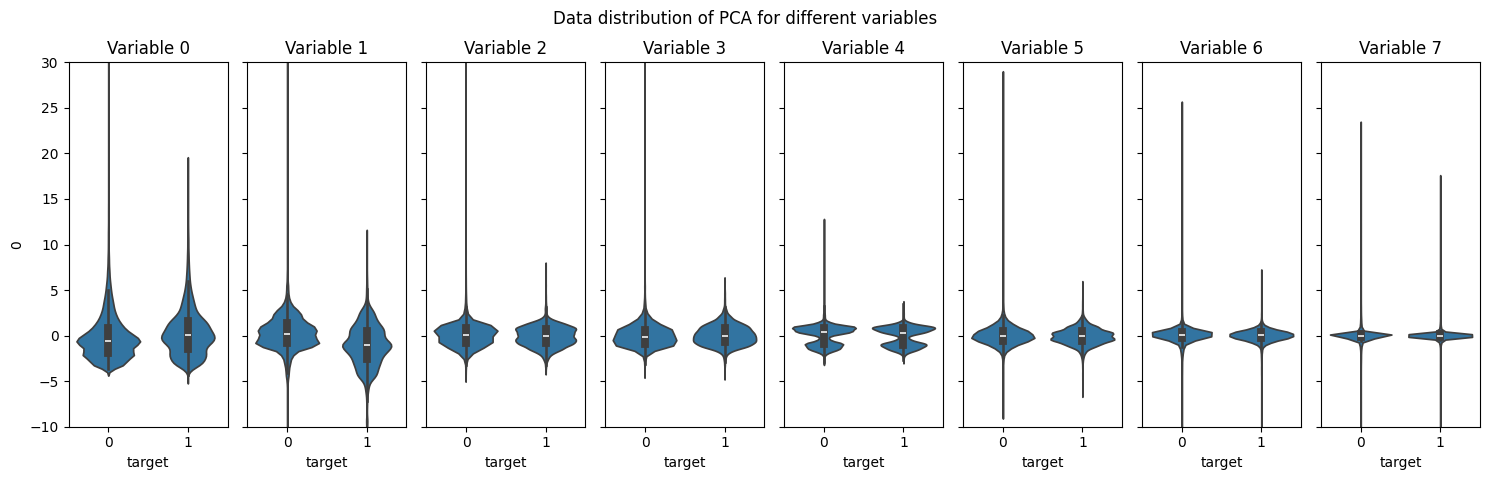

In [51]:
pca = PCA(n_components=8)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X), columns=[str(i) for i in range(8)])

df = X_pca.copy()
df['target'] = y

num_features = df.shape[1] - 1
fig, axes = plt.subplots(1, num_features, figsize=(15, 5), sharey=True)

for i, (feature, data) in enumerate(X_pca.items()):
    sns.violinplot(data=df, x='target', y=feature, ax=axes[i])
    axes[i].set_title("Variable " + str(i))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.ylim(-10, 30)
plt.suptitle("Data distribution of PCA for different variables")
plt.show()

# LDA

In [52]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(X, y)
X_lda = pd.DataFrame(LDA.transform(X))

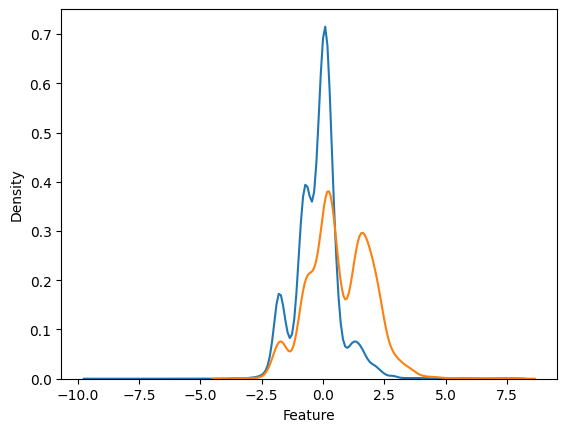

In [53]:
df['Feature'] = pd.DataFrame(data=X_lda)
df["Class"] = y

plt.figure()
sns.kdeplot(data=df[df['Class'] == 0]['Feature'])
sns.kdeplot(data=df[df['Class'] == 1]['Feature'])
plt.show()

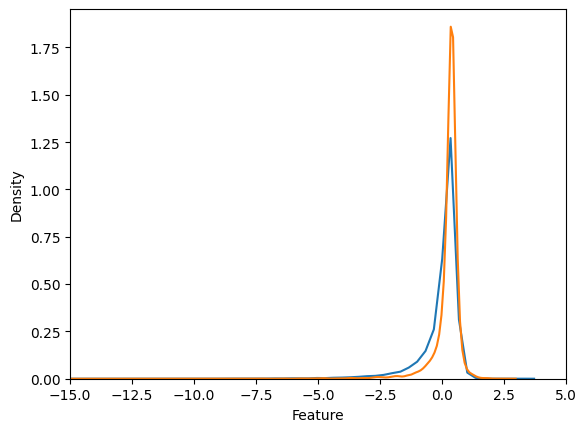

In [17]:
cols = ['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
LDA = LinearDiscriminantAnalysis()
LDA.fit(X[cols], y)
X_lda = pd.DataFrame(LDA.transform(X[cols]))
X_lda.head()

df = pd.DataFrame({'Feature': X_lda[0], 'Class': y})
plt.figure()
sns.kdeplot(data=df[df['Class'] == 0]['Feature'])
sns.kdeplot(data=df[df['Class'] == 1]['Feature'])
plt.xlim(-15, 5)
plt.show()

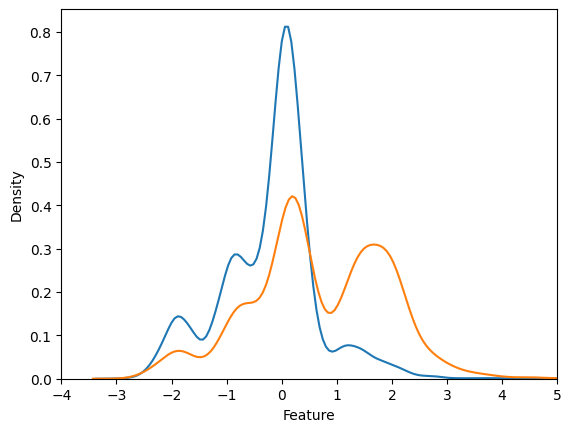

In [18]:

cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
LDA = LinearDiscriminantAnalysis()
LDA.fit(X[cols], y)
X_lda = pd.DataFrame(LDA.transform(X[cols]))
X_lda.head()

df = pd.DataFrame({'Feature': X_lda[0], 'Class': y})
plt.figure()
sns.kdeplot(data=df[df['Class'] == 0]['Feature'])
sns.kdeplot(data=df[df['Class'] == 1]['Feature'])
plt.xlim(-4, 5)
plt.show()

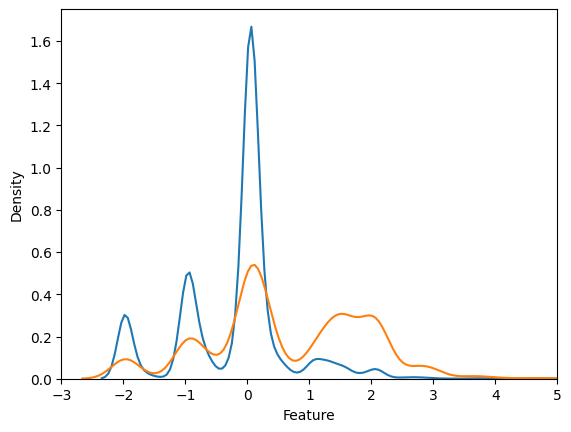

In [81]:
cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
LDA = LinearDiscriminantAnalysis()
LDA.fit(X[cols], y)
X_lda = pd.DataFrame(LDA.transform(X[cols]))
X_lda.head()

df = pd.DataFrame({'Feature': X_lda[0], 'Class': y})
plt.figure()
sns.kdeplot(data=df[df['Class'] == 0]['Feature'])
sns.kdeplot(data=df[df['Class'] == 1]['Feature'])
plt.xlim(-3, 5)
plt.show()
# TODO: adicionar este ao relatório

# ROC

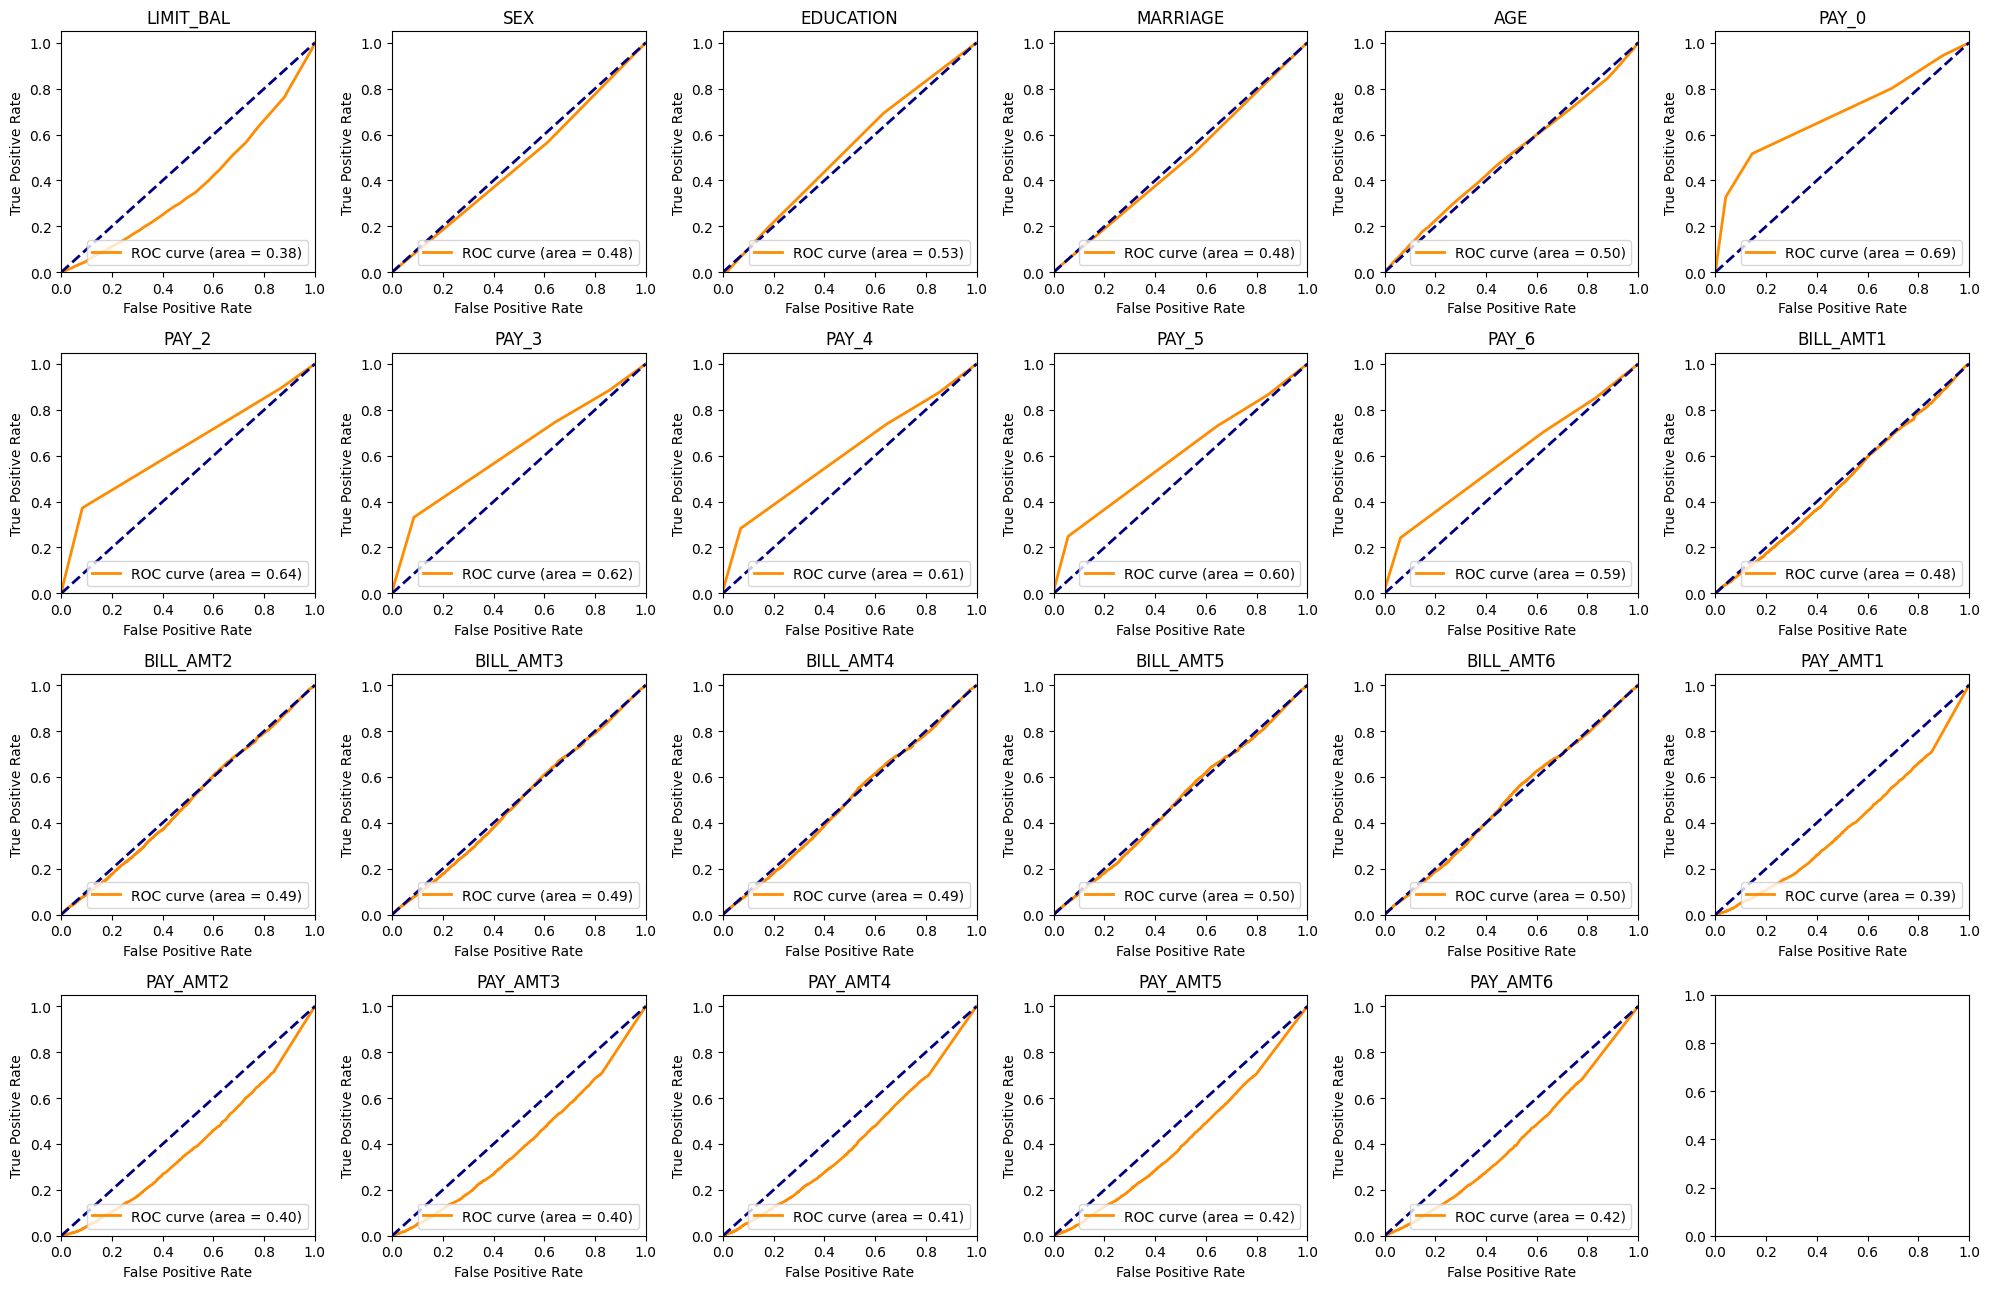

In [79]:
fig, axes = plt.subplots(4, 6, figsize=(20, 13))

for i, feature in enumerate(X.columns):
    fpr, tpr, thresholds = roc_curve(y, X[feature])
    roc_auc = auc(fpr, tpr)

    axes[i//6, i%6].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axes[i//6, i%6].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    axes[i//6, i%6].set_xlim([0.0, 1.0])
    axes[i//6, i%6].set_ylim([0.0, 1.05])
    axes[i//6, i%6].set_xlabel('False Positive Rate')
    axes[i//6, i%6].set_ylabel('True Positive Rate')
    axes[i//6, i%6].legend(loc='lower right')
    axes[i//6, i%6].set_title(f'{feature}')

plt.tight_layout()
plt.show()

# Classificators

## MDC

In [6]:
class MinimumDistanceClassifierMahalanobis:
    def __init__(self):
        self.centroids = {}
        self.covariances = {}

    def fit(self, X_train, y_train):
        self.centroids = {c: X_train[y_train == c].mean() for c in np.unique(y_train)}
        self.covariances = {c: X_train[y_train == c].cov() for c in np.unique(y_train)}

    def predict(self, X_test):
        predictions = [
            min(
                self.centroids.keys(),
                key=lambda c: np.sqrt((x - self.centroids[c]) @ np.linalg.inv(self.covariances[c]) @ (x - self.centroids[c]))
            )
            for _, x in X_test.iterrows()
        ]
        return predictions
    
    def get_key(self):
        return self.centroids.keys()

In [29]:
euclidean_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=i, stratify=df_y)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    MDC = NearestCentroid(metric='euclidean')
    MDC.fit(X_train, y_train)
    predictions = MDC.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    euclidean_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    euclidean_error["sensitivity_score"].append(tp / (tp + fn))
    euclidean_error["specificity_score"].append(tn / (tn + fp))

euclidean_error = pd.DataFrame(euclidean_error, columns=euclidean_error.keys())

In [31]:
mahalanobis_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=i, stratify=df_y)

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    X_train_scaled.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    MMDC = MinimumDistanceClassifierMahalanobis()
    MMDC.fit(X_train_scaled, y_train)
    predictions = MMDC.predict(X_test_scaled)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    mahalanobis_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    mahalanobis_error["sensitivity_score"].append(tp / (tp + fn))
    mahalanobis_error["specificity_score"].append(tn / (tn + fp))

mahalanobis_error = pd.DataFrame(mahalanobis_error)

## Gaussian Naive BayesNaive Bayes

In [32]:
nbb_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=i, stratify=df_y)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    GNB = GaussianNB()
    GNB.fit(X_train, y_train)
    predictions = GNB.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    nbb_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    nbb_error["sensitivity_score"].append(tp / (tp + fn))
    nbb_error["specificity_score"].append(tn / (tn + fp))

nbb_error = pd.DataFrame(nbb_error, columns=nbb_error.keys())

## K-Nearest Neighbors Classifier

In [34]:
knn_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=i, stratify=df_y)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    KNN = KNeighborsClassifier()
    KNN.fit(X_train, y_train)
    predictions = KNN.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    knn_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    knn_error["sensitivity_score"].append(tp / (tp + fn))
    knn_error["specificity_score"].append(tn / (tn + fp))

knn_error = pd.DataFrame(knn_error, columns=knn_error.keys())

## Suport Vector Machine

In [36]:
svm_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(5):
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=i, stratify=df_y)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    SVM = SVC()
    SVM.fit(X_train, y_train)
    predictions = SVM.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    svm_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    svm_error["sensitivity_score"].append(tp / (tp + fn))
    svm_error["specificity_score"].append(tn / (tn + fp))

svm_error = pd.DataFrame(svm_error, columns=svm_error.keys())

0
1
2
3
4


## Random Florests

In [37]:
rf_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=i, stratify=df_y)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    RF = RandomForestClassifier(max_depth=2, random_state=i)
    RF.fit(X_train, y_train)
    predictions = RF.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    rf_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    rf_error["sensitivity_score"].append(tp / (tp + fn))
    rf_error["specificity_score"].append(tn / (tn + fp))

rf_error = pd.DataFrame(rf_error, columns=rf_error.keys())

# Resultados

In [38]:
accuracy = {
    "Euclidean MDC": euclidean_error['accuracy_score'],
    "Mahalanobis MDC": mahalanobis_error['accuracy_score'],
    "Naive Bayes Classifier": nbb_error['accuracy_score'],
    "k-Nearest Neighbors": knn_error['accuracy_score'],
    "SVM": svm_error['accuracy_score'],
    "Random Florest": rf_error['accuracy_score'],
}
sensitivity = {
    "Euclidean MDC": euclidean_error['sensitivity_score'],
    "Mahalanobis MDC": mahalanobis_error['sensitivity_score'],
    "Naive Bayes Classifier": nbb_error['sensitivity_score'],
    "k-Nearest Neighbors": knn_error['sensitivity_score'],
    "SVM": svm_error['sensitivity_score'],
    "Random Florest": rf_error['sensitivity_score'],
}
specificity = {
    "Euclidean MDC": euclidean_error['specificity_score'],
    "Mahalanobis MDC": mahalanobis_error['specificity_score'],
    "Naive Bayes Classifier": nbb_error['specificity_score'],
    "k-Nearest Neighbors": knn_error['specificity_score'],
    "SVM": svm_error['specificity_score'],
    "Random Florest": rf_error['specificity_score'],
}
accuracy = pd.DataFrame(accuracy, columns=accuracy.keys())
sensitivity = pd.DataFrame(sensitivity, columns=sensitivity.keys())
specificity = pd.DataFrame(specificity, columns=specificity.keys())

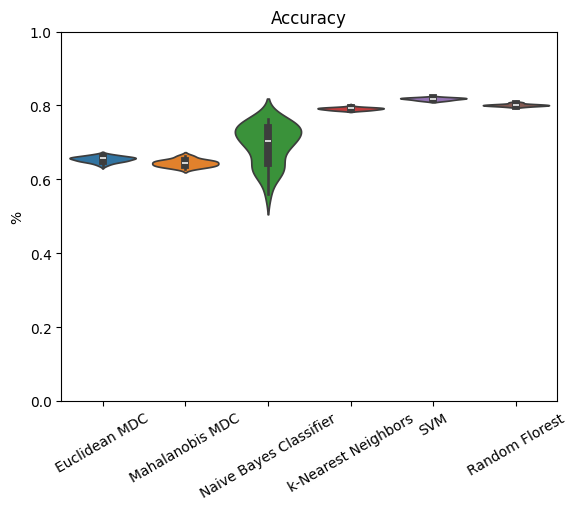

In [39]:
plt.figure()

sns.violinplot(data=accuracy)

plt.title("Accuracy")
plt.ylim(0, 1)
plt.ylabel("%")
plt.xticks(rotation=30)

plt.show()

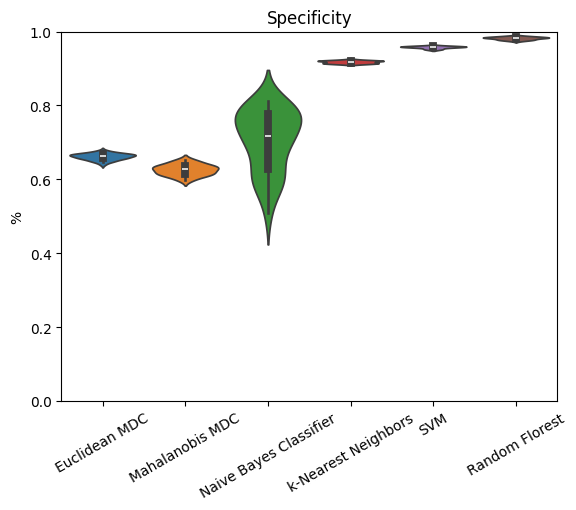

In [40]:
plt.figure()

sns.violinplot(data=specificity)

plt.title("Specificity")
plt.ylim(0, 1)
plt.ylabel("%")
plt.xticks(rotation=30)

plt.show()

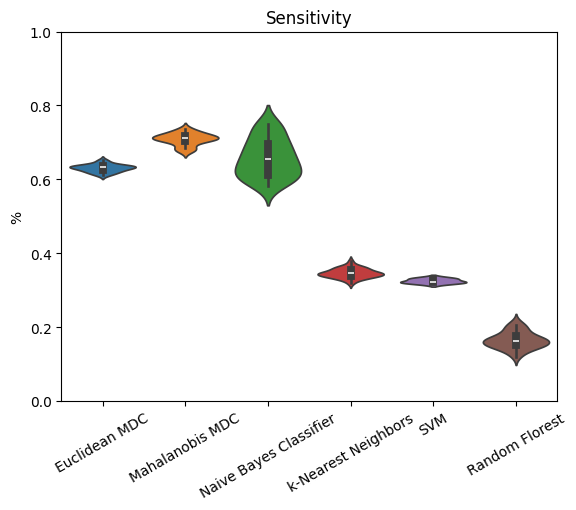

In [41]:
plt.figure()

sns.violinplot(data=sensitivity)

plt.title("Sensitivity")
plt.ylim(0, 1)
plt.ylabel("%")
plt.xticks(rotation=30)

plt.show()

# Classification with K-W

In [5]:
def classification(MODEL, cols, runs):
    metrics = {
        'accuracy_score': [],
        'sensitivity_score': [],
        'specificity_score': []
    }
    for i in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(df_X[cols], df_y, test_size=0.2, random_state=i, stratify=df_y)

        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

        scaler = StandardScaler()
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

        model = MODEL()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        metrics["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
        metrics["sensitivity_score"].append(tp / (tp + fn))
        metrics["specificity_score"].append(tn / (tn + fp))
    return metrics

## MDC

In [46]:
cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
eucl_kw_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(df_X[cols], df_y, test_size=0.2, random_state=i, stratify=df_y)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    MDC = NearestCentroid(metric='euclidean')
    MDC.fit(X_train, y_train)
    predictions = MDC.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    eucl_kw_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    eucl_kw_error["sensitivity_score"].append(tp / (tp + fn))
    eucl_kw_error["specificity_score"].append(tn / (tn + fp))

eucl_kw_error = pd.DataFrame(eucl_kw_error, columns=eucl_kw_error.keys())

In [49]:
cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
maha_kw_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=i, stratify=df_y)

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    X_train_scaled.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    MMDC = MinimumDistanceClassifierMahalanobis()
    MMDC.fit(X_train_scaled, y_train)
    predictions = MMDC.predict(X_test_scaled)

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    maha_kw_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    maha_kw_error["sensitivity_score"].append(tp / (tp + fn))
    maha_kw_error["specificity_score"].append(tn / (tn + fp))

maha_kw_error = pd.DataFrame(maha_kw_error, columns=maha_kw_error.keys())

## Gaussian Naive BayesNaive Bayes

In [56]:
cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
nbb_kw_error = classification(GaussianNB, cols, 30)

## K-Nearest Neighbors Classifier

In [59]:
cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
knn_kw_error = classification(KNeighborsClassifier, cols, 30)

## Suport Vector Machine

In [64]:
cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
svm_kw_error = classification(SVC, cols, 5)

## Random Florest

In [65]:
cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
rf_kw_error = classification(RandomForestClassifier, cols, 10)

## Results

In [67]:
eucl_kw_error = pd.DataFrame(eucl_kw_error, columns=eucl_kw_error.keys())
maha_kw_error = pd.DataFrame(maha_kw_error, columns=maha_kw_error.keys())
nbb_kw_error = pd.DataFrame(nbb_kw_error, columns=nbb_kw_error.keys())
knn_kw_error = pd.DataFrame(knn_kw_error, columns=knn_kw_error.keys())
svm_kw_error = pd.DataFrame(svm_kw_error, columns=svm_kw_error.keys())
rf_kw_error = pd.DataFrame(rf_kw_error, columns=rf_kw_error.keys())

accuracy = {
    "Euclidean MDC":         eucl_kw_error['accuracy_score'],
    "Mahalanobis MDC":       maha_kw_error['accuracy_score'],
    "Naive Bayes Classifier": nbb_kw_error['accuracy_score'],
    "k-Nearest Neighbors":    knn_kw_error['accuracy_score'],
    "SVM":                    svm_kw_error['accuracy_score'],
    "Random Florest":          rf_kw_error['accuracy_score'],
}
sensitivity = {
    "Euclidean MDC":          eucl_kw_error['sensitivity_score'],
    "Mahalanobis MDC":        maha_kw_error['sensitivity_score'],
    "Naive Bayes Classifier":  nbb_kw_error['sensitivity_score'],
    "k-Nearest Neighbors":     knn_kw_error['sensitivity_score'],
    "SVM":                     svm_kw_error['sensitivity_score'],
    "Random Florest":           rf_kw_error['sensitivity_score'],
}
specificity = {
    "Euclidean MDC":          eucl_kw_error['specificity_score'],
    "Mahalanobis MDC":        maha_kw_error['specificity_score'],
    "Naive Bayes Classifier":  nbb_kw_error['specificity_score'],
    "k-Nearest Neighbors":     knn_kw_error['specificity_score'],
    "SVM":                     svm_kw_error['specificity_score'],
    "Random Florest":           rf_kw_error['specificity_score'],
}
accuracy = pd.DataFrame(accuracy, columns=accuracy.keys())
sensitivity = pd.DataFrame(sensitivity, columns=sensitivity.keys())
specificity = pd.DataFrame(specificity, columns=specificity.keys())

In [15]:
def result(data, title):
    plt.figure()
    sns.violinplot(data=data)
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel("%")
    plt.xticks(rotation=30)
    plt.show()

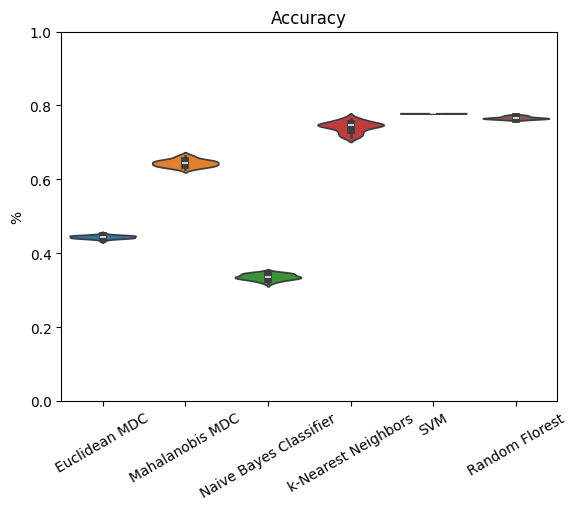

In [72]:
result(accuracy, "Accuracy")

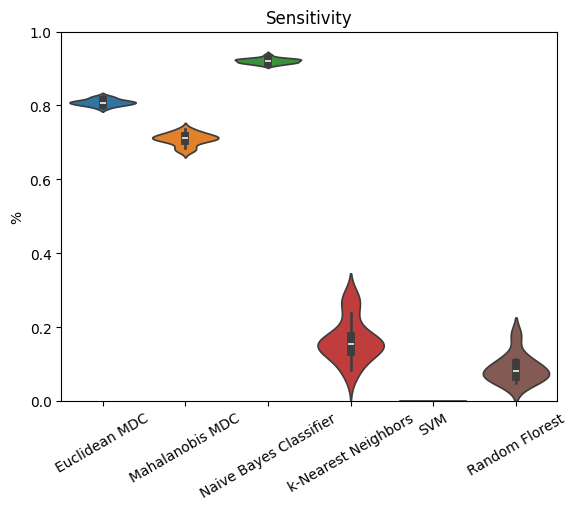

In [71]:
result(sensitivity, "Sensitivity")

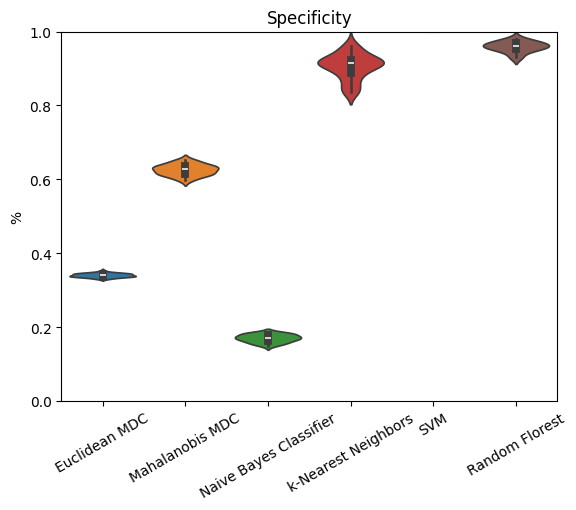

In [73]:
result(specificity, "Specificity")

# Classification with ROC

## MDC

In [7]:
cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
eucl_roc_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(df_X[cols], df_y, test_size=0.2, random_state=i, stratify=df_y)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    MDC = NearestCentroid(metric='euclidean')
    MDC.fit(X_train, y_train)
    predictions = MDC.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    eucl_roc_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    eucl_roc_error["sensitivity_score"].append(tp / (tp + fn))
    eucl_roc_error["specificity_score"].append(tn / (tn + fp))

In [11]:
cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
maha_roc_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=i, stratify=df_y)

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    X_train_scaled.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    MMDC = MinimumDistanceClassifierMahalanobis()
    MMDC.fit(X_train_scaled, y_train)
    predictions = MMDC.predict(X_test_scaled)

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    maha_roc_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    maha_roc_error["sensitivity_score"].append(tp / (tp + fn))
    maha_roc_error["specificity_score"].append(tn / (tn + fp))

## Gaussian Naive BayesNaive Bayes

In [8]:
cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
nbb_roc_error = classification(GaussianNB, cols, 30)

## K-Nearest Neighbors Classifier

In [10]:
knn_roc_error = classification(KNeighborsClassifier, cols, 30)

## Suport Vector Machine

In [12]:
svm_roc_error = classification(SVC, cols, 5)

## Random Florest

In [9]:
rf_roc_error = classification(RandomForestClassifier, cols, 30)

# Results

In [13]:
eucl_roc_error = pd.DataFrame(eucl_roc_error, columns=eucl_roc_error.keys())
maha_roc_error = pd.DataFrame(maha_roc_error, columns=maha_roc_error.keys())
nbb_roc_error = pd.DataFrame(nbb_roc_error, columns=nbb_roc_error.keys())
knn_roc_error = pd.DataFrame(knn_roc_error, columns=knn_roc_error.keys())
svm_roc_error = pd.DataFrame(svm_roc_error, columns=svm_roc_error.keys())
rf_roc_error = pd.DataFrame(rf_roc_error, columns=rf_roc_error.keys())

accuracy = {
    "Euclidean MDC":         eucl_roc_error['accuracy_score'],
    "Mahalanobis MDC":       maha_roc_error['accuracy_score'],
    "Naive Bayes Classifier": nbb_roc_error['accuracy_score'],
    "k-Nearest Neighbors":    knn_roc_error['accuracy_score'],
    "SVM":                    svm_roc_error['accuracy_score'],
    "Random Florest":          rf_roc_error['accuracy_score'],
}
sensitivity = {
    "Euclidean MDC":          eucl_roc_error['sensitivity_score'],
    "Mahalanobis MDC":        maha_roc_error['sensitivity_score'],
    "Naive Bayes Classifier":  nbb_roc_error['sensitivity_score'],
    "k-Nearest Neighbors":     knn_roc_error['sensitivity_score'],
    "SVM":                     svm_roc_error['sensitivity_score'],
    "Random Florest":           rf_roc_error['sensitivity_score'],
}
specificity = {
    "Euclidean MDC":          eucl_roc_error['specificity_score'],
    "Mahalanobis MDC":        maha_roc_error['specificity_score'],
    "Naive Bayes Classifier":  nbb_roc_error['specificity_score'],
    "k-Nearest Neighbors":     knn_roc_error['specificity_score'],
    "SVM":                     svm_roc_error['specificity_score'],
    "Random Florest":           rf_roc_error['specificity_score'],
}
accuracy = pd.DataFrame(accuracy, columns=accuracy.keys())
sensitivity = pd.DataFrame(sensitivity, columns=sensitivity.keys())
specificity = pd.DataFrame(specificity, columns=specificity.keys())

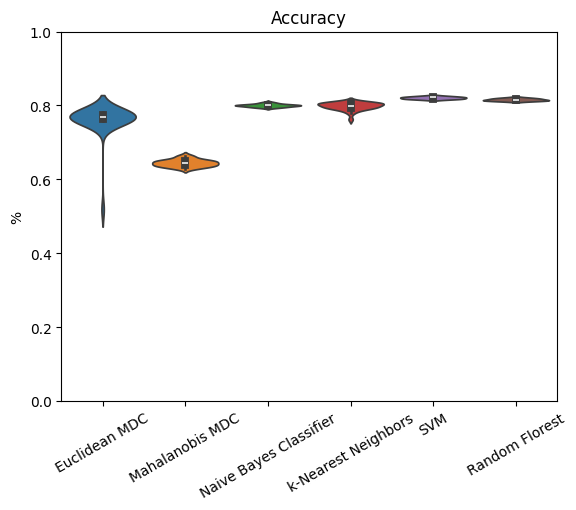

In [16]:
result(accuracy, "Accuracy")

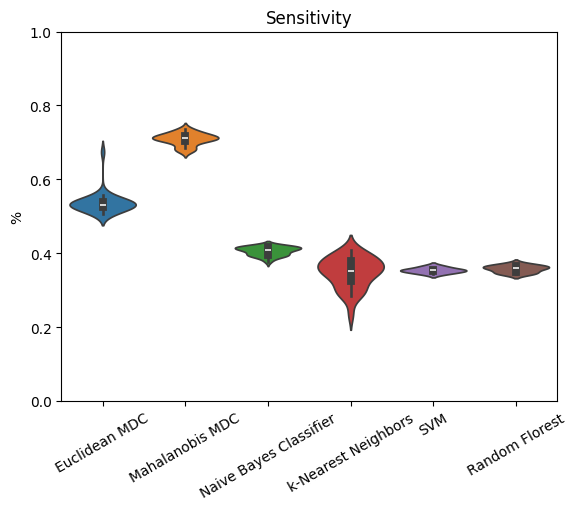

In [17]:
result(sensitivity, "Sensitivity")

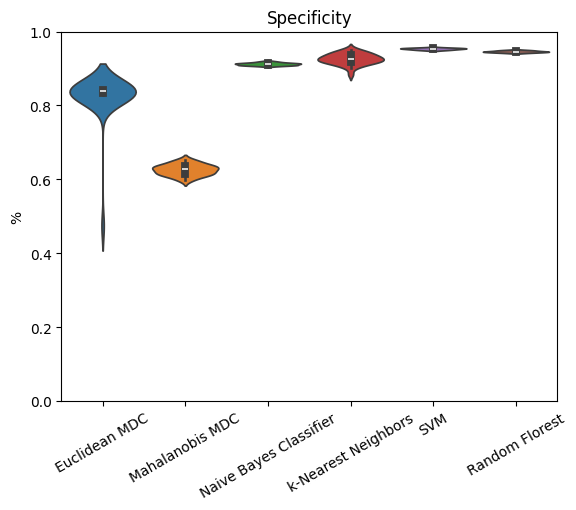

In [18]:
result(specificity, "Specificity")

# Classification with PCA

In [22]:
def classification(MODEL, dataX, dataY, runs):
    metrics = {
        'accuracy_score': [],
        'sensitivity_score': [],
        'specificity_score': []
    }
    for i in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=i, stratify=dataY)

        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

        scaler = StandardScaler()
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

        model = MODEL()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        metrics["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
        metrics["sensitivity_score"].append(tp / (tp + fn))
        metrics["specificity_score"].append(tn / (tn + fp))
    return metrics

## MDC

In [21]:
pca = PCA(n_components=8)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X), columns=[str(i) for i in range(8)])

eucl_pca_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=i, stratify=y)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    MDC = NearestCentroid(metric='euclidean')
    MDC.fit(X_train, y_train)
    predictions = MDC.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    eucl_pca_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    eucl_pca_error["sensitivity_score"].append(tp / (tp + fn))
    eucl_pca_error["specificity_score"].append(tn / (tn + fp))

In [23]:
maha_pca_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=i, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    X_train_scaled.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    MMDC = MinimumDistanceClassifierMahalanobis()
    MMDC.fit(X_train_scaled, y_train)
    predictions = MMDC.predict(X_test_scaled)

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    maha_pca_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    maha_pca_error["sensitivity_score"].append(tp / (tp + fn))
    maha_pca_error["specificity_score"].append(tn / (tn + fp))
print("end")
nbb_pca_error = classification(GaussianNB, X_pca, y, 30)
print("end")
knn_pca_error = classification(KNeighborsClassifier, X_pca, y, 30)
print("end")
svm_pca_error = classification(SVC, X_pca, y, 5)
print("end")
rf_pca_error = classification(RandomForestClassifier, X_pca, y, 30)
print("end")

end
end
end
end
end


In [24]:
eucl_pca_error = pd.DataFrame(eucl_pca_error, columns=eucl_pca_error.keys())
maha_pca_error = pd.DataFrame(maha_pca_error, columns=maha_pca_error.keys())
nbb_pca_error = pd.DataFrame(nbb_pca_error, columns=nbb_pca_error.keys())
knn_pca_error = pd.DataFrame(knn_pca_error, columns=knn_pca_error.keys())
svm_pca_error = pd.DataFrame(svm_pca_error, columns=svm_pca_error.keys())
rf_pca_error = pd.DataFrame(rf_pca_error, columns=rf_pca_error.keys())

accuracy = {
    "Euclidean MDC":         eucl_pca_error['accuracy_score'],
    "Mahalanobis MDC":       maha_pca_error['accuracy_score'],
    "Naive Bayes Classifier": nbb_pca_error['accuracy_score'],
    "k-Nearest Neighbors":    knn_pca_error['accuracy_score'],
    "SVM":                    svm_pca_error['accuracy_score'],
    "Random Florest":          rf_pca_error['accuracy_score'],
}
sensitivity = {
    "Euclidean MDC":          eucl_pca_error['sensitivity_score'],
    "Mahalanobis MDC":        maha_pca_error['sensitivity_score'],
    "Naive Bayes Classifier":  nbb_pca_error['sensitivity_score'],
    "k-Nearest Neighbors":     knn_pca_error['sensitivity_score'],
    "SVM":                     svm_pca_error['sensitivity_score'],
    "Random Florest":           rf_pca_error['sensitivity_score'],
}
specificity = {
    "Euclidean MDC":          eucl_pca_error['specificity_score'],
    "Mahalanobis MDC":        maha_pca_error['specificity_score'],
    "Naive Bayes Classifier":  nbb_pca_error['specificity_score'],
    "k-Nearest Neighbors":     knn_pca_error['specificity_score'],
    "SVM":                     svm_pca_error['specificity_score'],
    "Random Florest":           rf_pca_error['specificity_score'],
}
accuracy = pd.DataFrame(accuracy, columns=accuracy.keys())
sensitivity = pd.DataFrame(sensitivity, columns=sensitivity.keys())
specificity = pd.DataFrame(specificity, columns=specificity.keys())

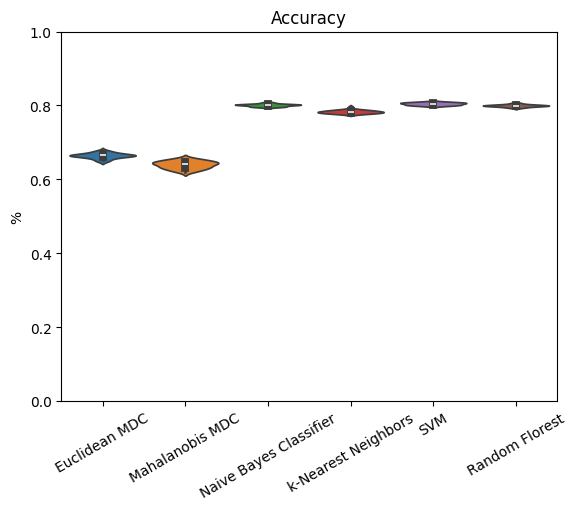

In [25]:
result(accuracy, "Accuracy")

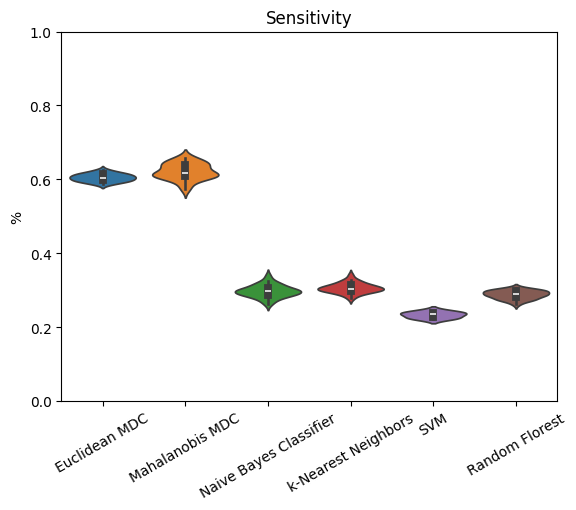

In [26]:
result(sensitivity, "Sensitivity")

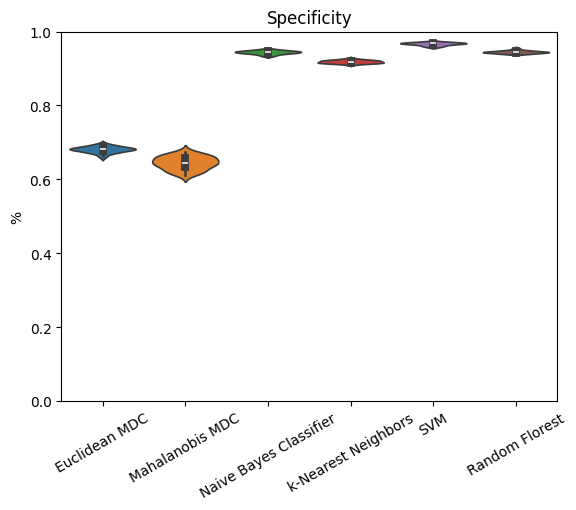

In [27]:
result(specificity, "Specificity")

# Fisher LDA

## MDC

In [28]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(X, y)
X_lda = pd.DataFrame(LDA.transform(X))

eucl_lda_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=i, stratify=y)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    MDC = NearestCentroid(metric='euclidean')
    MDC.fit(X_train, y_train)
    predictions = MDC.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    eucl_lda_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    eucl_lda_error["sensitivity_score"].append(tp / (tp + fn))
    eucl_lda_error["specificity_score"].append(tn / (tn + fp))

print("end")

maha_lda_error = {
    'accuracy_score': [],
    'sensitivity_score': [],
    'specificity_score': []
}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=i, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    scaler = StandardScaler()
    X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    X_train_scaled.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    MMDC = MinimumDistanceClassifierMahalanobis()
    MMDC.fit(X_train_scaled, y_train)
    predictions = MMDC.predict(X_test_scaled)

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    maha_lda_error["accuracy_score"].append((tp + tn) / (tp + tn + fp + fn))
    maha_lda_error["sensitivity_score"].append(tp / (tp + fn))
    maha_lda_error["specificity_score"].append(tn / (tn + fp))

print("end")
nbb_lda_error = classification(GaussianNB, X_lda, y, 30)
print("end")
knn_lda_error = classification(KNeighborsClassifier, X_lda, y, 30)
print("end")
svm_lda_error = classification(SVC, X_lda, y, 5)
print("end")
rf_lda_error = classification(RandomForestClassifier, X_pca, y, 30)
print("end")

end
end
end
end
end
end


In [29]:

eucl_lda_error = pd.DataFrame(eucl_lda_error, columns=eucl_lda_error.keys())
maha_lda_error = pd.DataFrame(maha_lda_error, columns=maha_lda_error.keys())
nbb_lda_error = pd.DataFrame(nbb_lda_error, columns=nbb_lda_error.keys())
knn_lda_error = pd.DataFrame(knn_lda_error, columns=knn_lda_error.keys())
svm_lda_error = pd.DataFrame(svm_lda_error, columns=svm_lda_error.keys())
rf_lda_error = pd.DataFrame(rf_lda_error, columns=rf_lda_error.keys())

accuracy = {
    "Euclidean MDC":          eucl_lda_error['accuracy_score'],
    "Mahalanobis MDC":        maha_lda_error['accuracy_score'],
    "Naive Bayes Classifier":  nbb_lda_error['accuracy_score'],
    "k-Nearest Neighbors":     knn_lda_error['accuracy_score'],
    "SVM":                     svm_lda_error['accuracy_score'],
    "Random Florest":           rf_lda_error['accuracy_score'],
}
sensitivity = {
    "Euclidean MDC":          eucl_lda_error['sensitivity_score'],
    "Mahalanobis MDC":        maha_lda_error['sensitivity_score'],
    "Naive Bayes Classifier":  nbb_lda_error['sensitivity_score'],
    "k-Nearest Neighbors":     knn_lda_error['sensitivity_score'],
    "SVM":                     svm_lda_error['sensitivity_score'],
    "Random Florest":           rf_lda_error['sensitivity_score'],
}
specificity = {
    "Euclidean MDC":          eucl_lda_error['specificity_score'],
    "Mahalanobis MDC":        maha_lda_error['specificity_score'],
    "Naive Bayes Classifier":  nbb_lda_error['specificity_score'],
    "k-Nearest Neighbors":     knn_lda_error['specificity_score'],
    "SVM":                     svm_lda_error['specificity_score'],
    "Random Florest":           rf_lda_error['specificity_score'],
}
accuracy = pd.DataFrame(accuracy, columns=accuracy.keys())
sensitivity = pd.DataFrame(sensitivity, columns=sensitivity.keys())
specificity = pd.DataFrame(specificity, columns=specificity.keys())

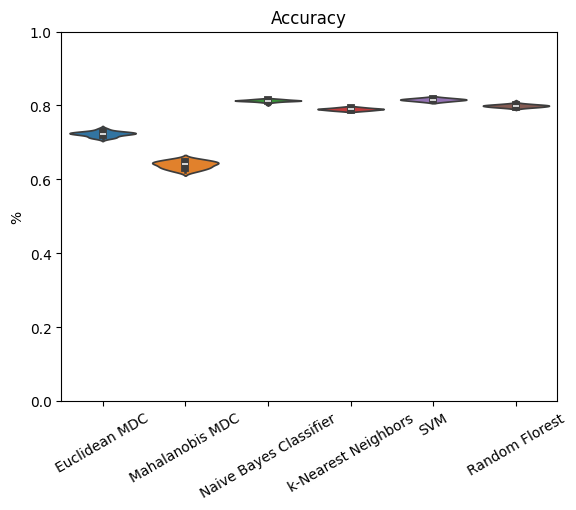

In [30]:
result(accuracy, "Accuracy")

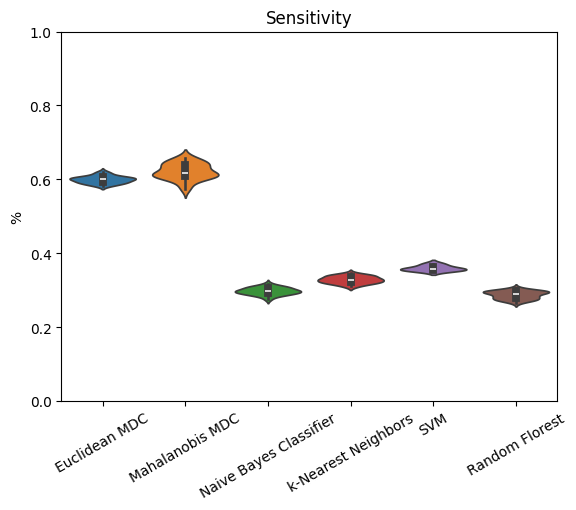

In [31]:
result(sensitivity, "Sensitivity")

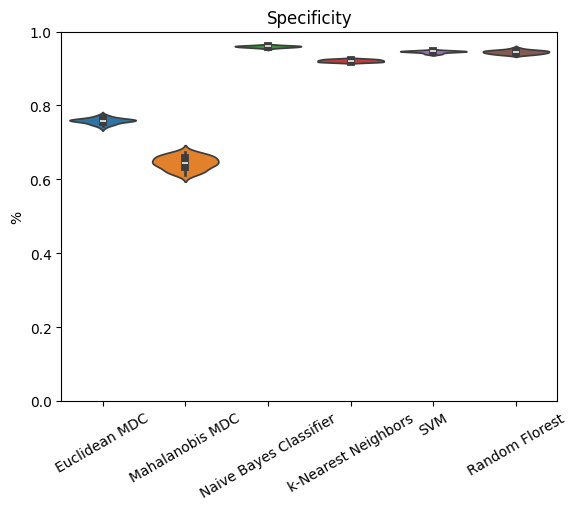

In [32]:
result(specificity, "Specificity")